# 🐔 CHICKEN DETECTION TRAINING (HEALTHY vs SICK)

**Dataset:** 3,175 ảnh (merged)
- Train: 2,781 ảnh
- Valid: 277 ảnh
- Test: 117 ảnh

**Classes:**
- Class 0: healthyChicken
- Class 1: sickChicken

**Model:** YOLOv8n / YOLOv11n (Object Detection)

---

## 📦 BƯỚC 1: CÀI ĐẶT ULTRALYTICS

In [6]:
# Cài đặt Ultralytics (YOLOv8/v11)
!pip install ultralytics -q

# Import libraries
from ultralytics import YOLO
import torch
from pathlib import Path
import shutil

# Kiểm tra GPU
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("⚠️ WARNING: No GPU detected! Training will be slow.")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
CUDA version: 12.6


## 📂 BƯỚC 2: MOUNT GOOGLE DRIVE & UPLOAD DATASET

### **Hướng dẫn upload dataset:**

1. **Nén dataset trên máy local:**
   ```powershell
   # Trên Windows PowerShell
   Compress-Archive -Path "d:\train_chicken\02_detection\data\merged_dataset" -DestinationPath "d:\train_chicken\merged_dataset.zip"
   ```

2. **Upload lên Google Drive:**
   - Vào Google Drive
   - Tạo thư mục: `chicken_detection`
   - Upload file `merged_dataset.zip` vào thư mục đó

3. **Chạy cell dưới để mount Drive:**

In [8]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Đường dẫn dataset trên Drive
DRIVE_DATASET_ZIP = '/content/drive/MyDrive/chicken_detection/merged_dataset.zip'

# Kiểm tra file có tồn tại không
import os
if os.path.exists(DRIVE_DATASET_ZIP):
    print(f"✓ Tìm thấy dataset: {DRIVE_DATASET_ZIP}")
    file_size = os.path.getsize(DRIVE_DATASET_ZIP) / (1024**3)  # GB
    print(f"  Kích thước: {file_size:.2f} GB")
else:
    print(f"✗ KHÔNG tìm thấy dataset tại: {DRIVE_DATASET_ZIP}")
    print("  Vui lòng upload file merged_dataset.zip lên Google Drive!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Tìm thấy dataset: /content/drive/MyDrive/chicken_detection/merged_dataset.zip
  Kích thước: 0.13 GB


## 📦 BƯỚC 3: GIẢI NÉN DATASET

In [9]:
# Giải nén dataset
!unzip -q {DRIVE_DATASET_ZIP} -d /content/

# Kiểm tra cấu trúc
DATASET_ROOT = Path('/content/merged_dataset')
print(f"\n✓ Dataset location: {DATASET_ROOT}")
print(f"\nCấu trúc:")
!ls -lh /content/merged_dataset/

# Đếm số ảnh
train_imgs = len(list((DATASET_ROOT / 'train' / 'images').glob('*.jpg')))
valid_imgs = len(list((DATASET_ROOT / 'valid' / 'images').glob('*.jpg')))
test_imgs = len(list((DATASET_ROOT / 'test' / 'images').glob('*.jpg')))

print(f"\n📊 Số lượng ảnh:")
print(f"  Train: {train_imgs}")
print(f"  Valid: {valid_imgs}")
print(f"  Test:  {test_imgs}")
print(f"  Total: {train_imgs + valid_imgs + test_imgs}")


✓ Dataset location: /content/merged_dataset

Cấu trúc:
total 16K
-rw-rw-rw- 1 root root  266 Jan 15 16:55 data.yaml
drwxrwxrwx 4 root root 4.0K Jan 15 16:54 test
drwxrwxrwx 4 root root 4.0K Jan 15 16:54 train
drwxrwxrwx 4 root root 4.0K Jan 15 16:54 valid

📊 Số lượng ảnh:
  Train: 2781
  Valid: 277
  Test:  117
  Total: 3175


## 🔧 BƯỚC 4: CẬP NHẬT DATA.YAML

Cập nhật đường dẫn trong `data.yaml` cho Colab:

In [10]:
# Cập nhật data.yaml với đường dẫn tuyệt đối
yaml_content = f"""train: {DATASET_ROOT}/train/images
val: {DATASET_ROOT}/valid/images
test: {DATASET_ROOT}/test/images

nc: 2
names: ['healthyChicken', 'sickChicken']

# Merged from:
# - data_chicken_behavior (382 images, original)
# - data_chicken_behavior_2 (2,793 images, Roboflow, converted)
# Total: 3,175 images
"""

with open(DATASET_ROOT / 'data.yaml', 'w') as f:
    f.write(yaml_content)

print("✓ Đã cập nhật data.yaml")
print("\nNội dung data.yaml:")
!cat {DATASET_ROOT}/data.yaml

✓ Đã cập nhật data.yaml

Nội dung data.yaml:
train: /content/merged_dataset/train/images
val: /content/merged_dataset/valid/images
test: /content/merged_dataset/test/images

nc: 2
names: ['healthyChicken', 'sickChicken']

# Merged from:
# - data_chicken_behavior (382 images, original)
# - data_chicken_behavior_2 (2,793 images, Roboflow, converted)
# Total: 3,175 images


## 🚀 BƯỚC 5: TRAINING

### **Hyperparameters:**
- **Model:** YOLOv8n (nano - nhanh nhất)
- **Epochs:** 100 (có early stopping)
- **Image size:** 640
- **Batch size:** 16 (phù hợp với T4 16GB)
- **Patience:** 20 (early stopping)
- **Optimizer:** AdamW

### **Kỳ vọng:**
- **Thời gian:** ~2-3 giờ trên T4
- **mAP@50:** 85-90%
- **mAP@50:0.95:** 70-80%

In [11]:
# Load pretrained model
model = YOLO('yolov8n.pt')  # YOLOv8 nano
# Hoặc dùng YOLOv11: model = YOLO('yolo11n.pt')

print("✓ Đã load pretrained model")
print(f"\nModel: {model.model_name}")
print(f"Parameters: {sum(p.numel() for p in model.model.parameters()):,}")

✓ Đã load pretrained model

Model: yolov8n.pt
Parameters: 3,157,200


In [12]:
# Train model
results = model.train(
    data=str(DATASET_ROOT / 'data.yaml'),
    epochs=50,
    imgsz=640,
    batch=16,
    device=0,  # GPU
    patience=20,  # Early stopping
    save=True,
    project='/content/runs/detect',
    name='chicken_detection',
    exist_ok=True,
    plots=True,
    verbose=True,
    # Augmentation
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=10,
    translate=0.1,
    scale=0.5,
    shear=2.0,
    flipud=0.0,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.1
)

print("\n" + "="*80)
print("✅ TRAINING HOÀN TẤT!")
print("="*80)

Ultralytics 8.4.4 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/merged_dataset/data.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=chicken_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, 

## 📊 BƯỚC 6: ĐÁNH GIÁ MODEL

In [13]:
# Load best model
best_model = YOLO('/content/runs/detect/chicken_detection/weights/best.pt')

# Validate trên validation set
print("\n📊 VALIDATION METRICS:")
print("="*80)
val_metrics = best_model.val(data=str(DATASET_ROOT / 'data.yaml'))

# In kết quả
print(f"\nmAP@50: {val_metrics.box.map50:.4f}")
print(f"mAP@50:0.95: {val_metrics.box.map:.4f}")
print(f"Precision: {val_metrics.box.mp:.4f}")
print(f"Recall: {val_metrics.box.mr:.4f}")

# Test trên test set
print("\n📊 TEST METRICS:")
print("="*80)
test_metrics = best_model.val(
    data=str(DATASET_ROOT / 'data.yaml'),
    split='test'
)

print(f"\nmAP@50: {test_metrics.box.map50:.4f}")
print(f"mAP@50:0.95: {test_metrics.box.map:.4f}")
print(f"Precision: {test_metrics.box.mp:.4f}")
print(f"Recall: {test_metrics.box.mr:.4f}")


📊 VALIDATION METRICS:
Ultralytics 8.4.4 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1044.0±471.8 MB/s, size: 27.9 KB)
val: Scanning /content/merged_dataset/valid/labels.cache... 277 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 277/277 105.6Mit/s 0.0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 34, len(boxes) = 1322. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 3.6it/s 5.0s
                   all        277       1322      0.959      0.939      0.967      0.704
        healthyChicken        150        268      0.955      0.918      0.955      0.719
           sick

## 📈 BƯỚC 7: XEM KẾT QUẢ TRAINING

📈 TRAINING CURVES:


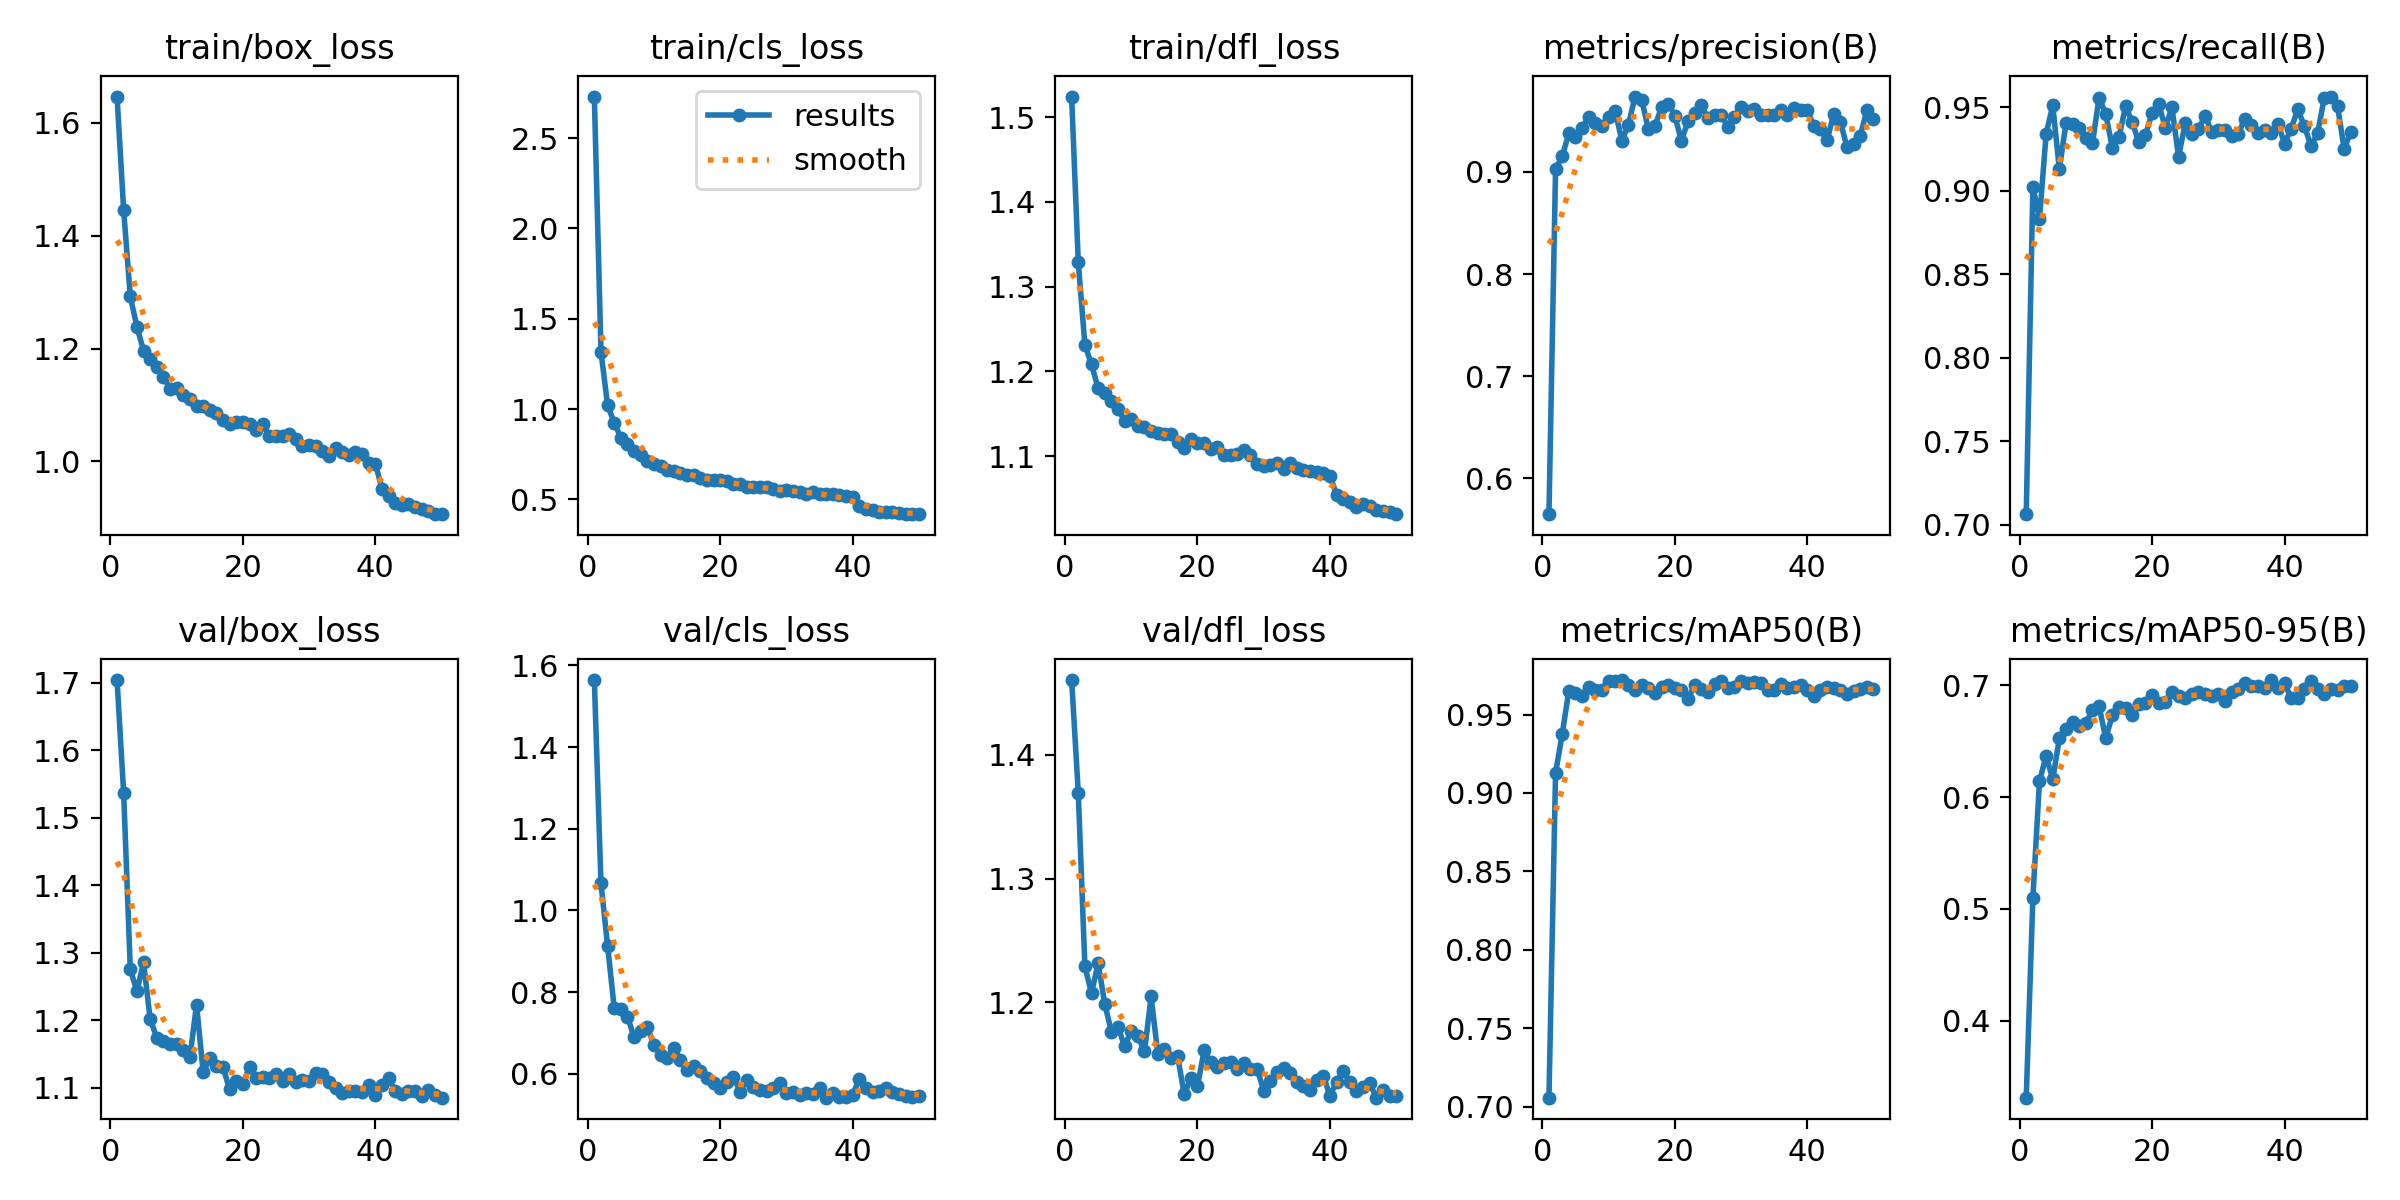


📊 CONFUSION MATRIX:


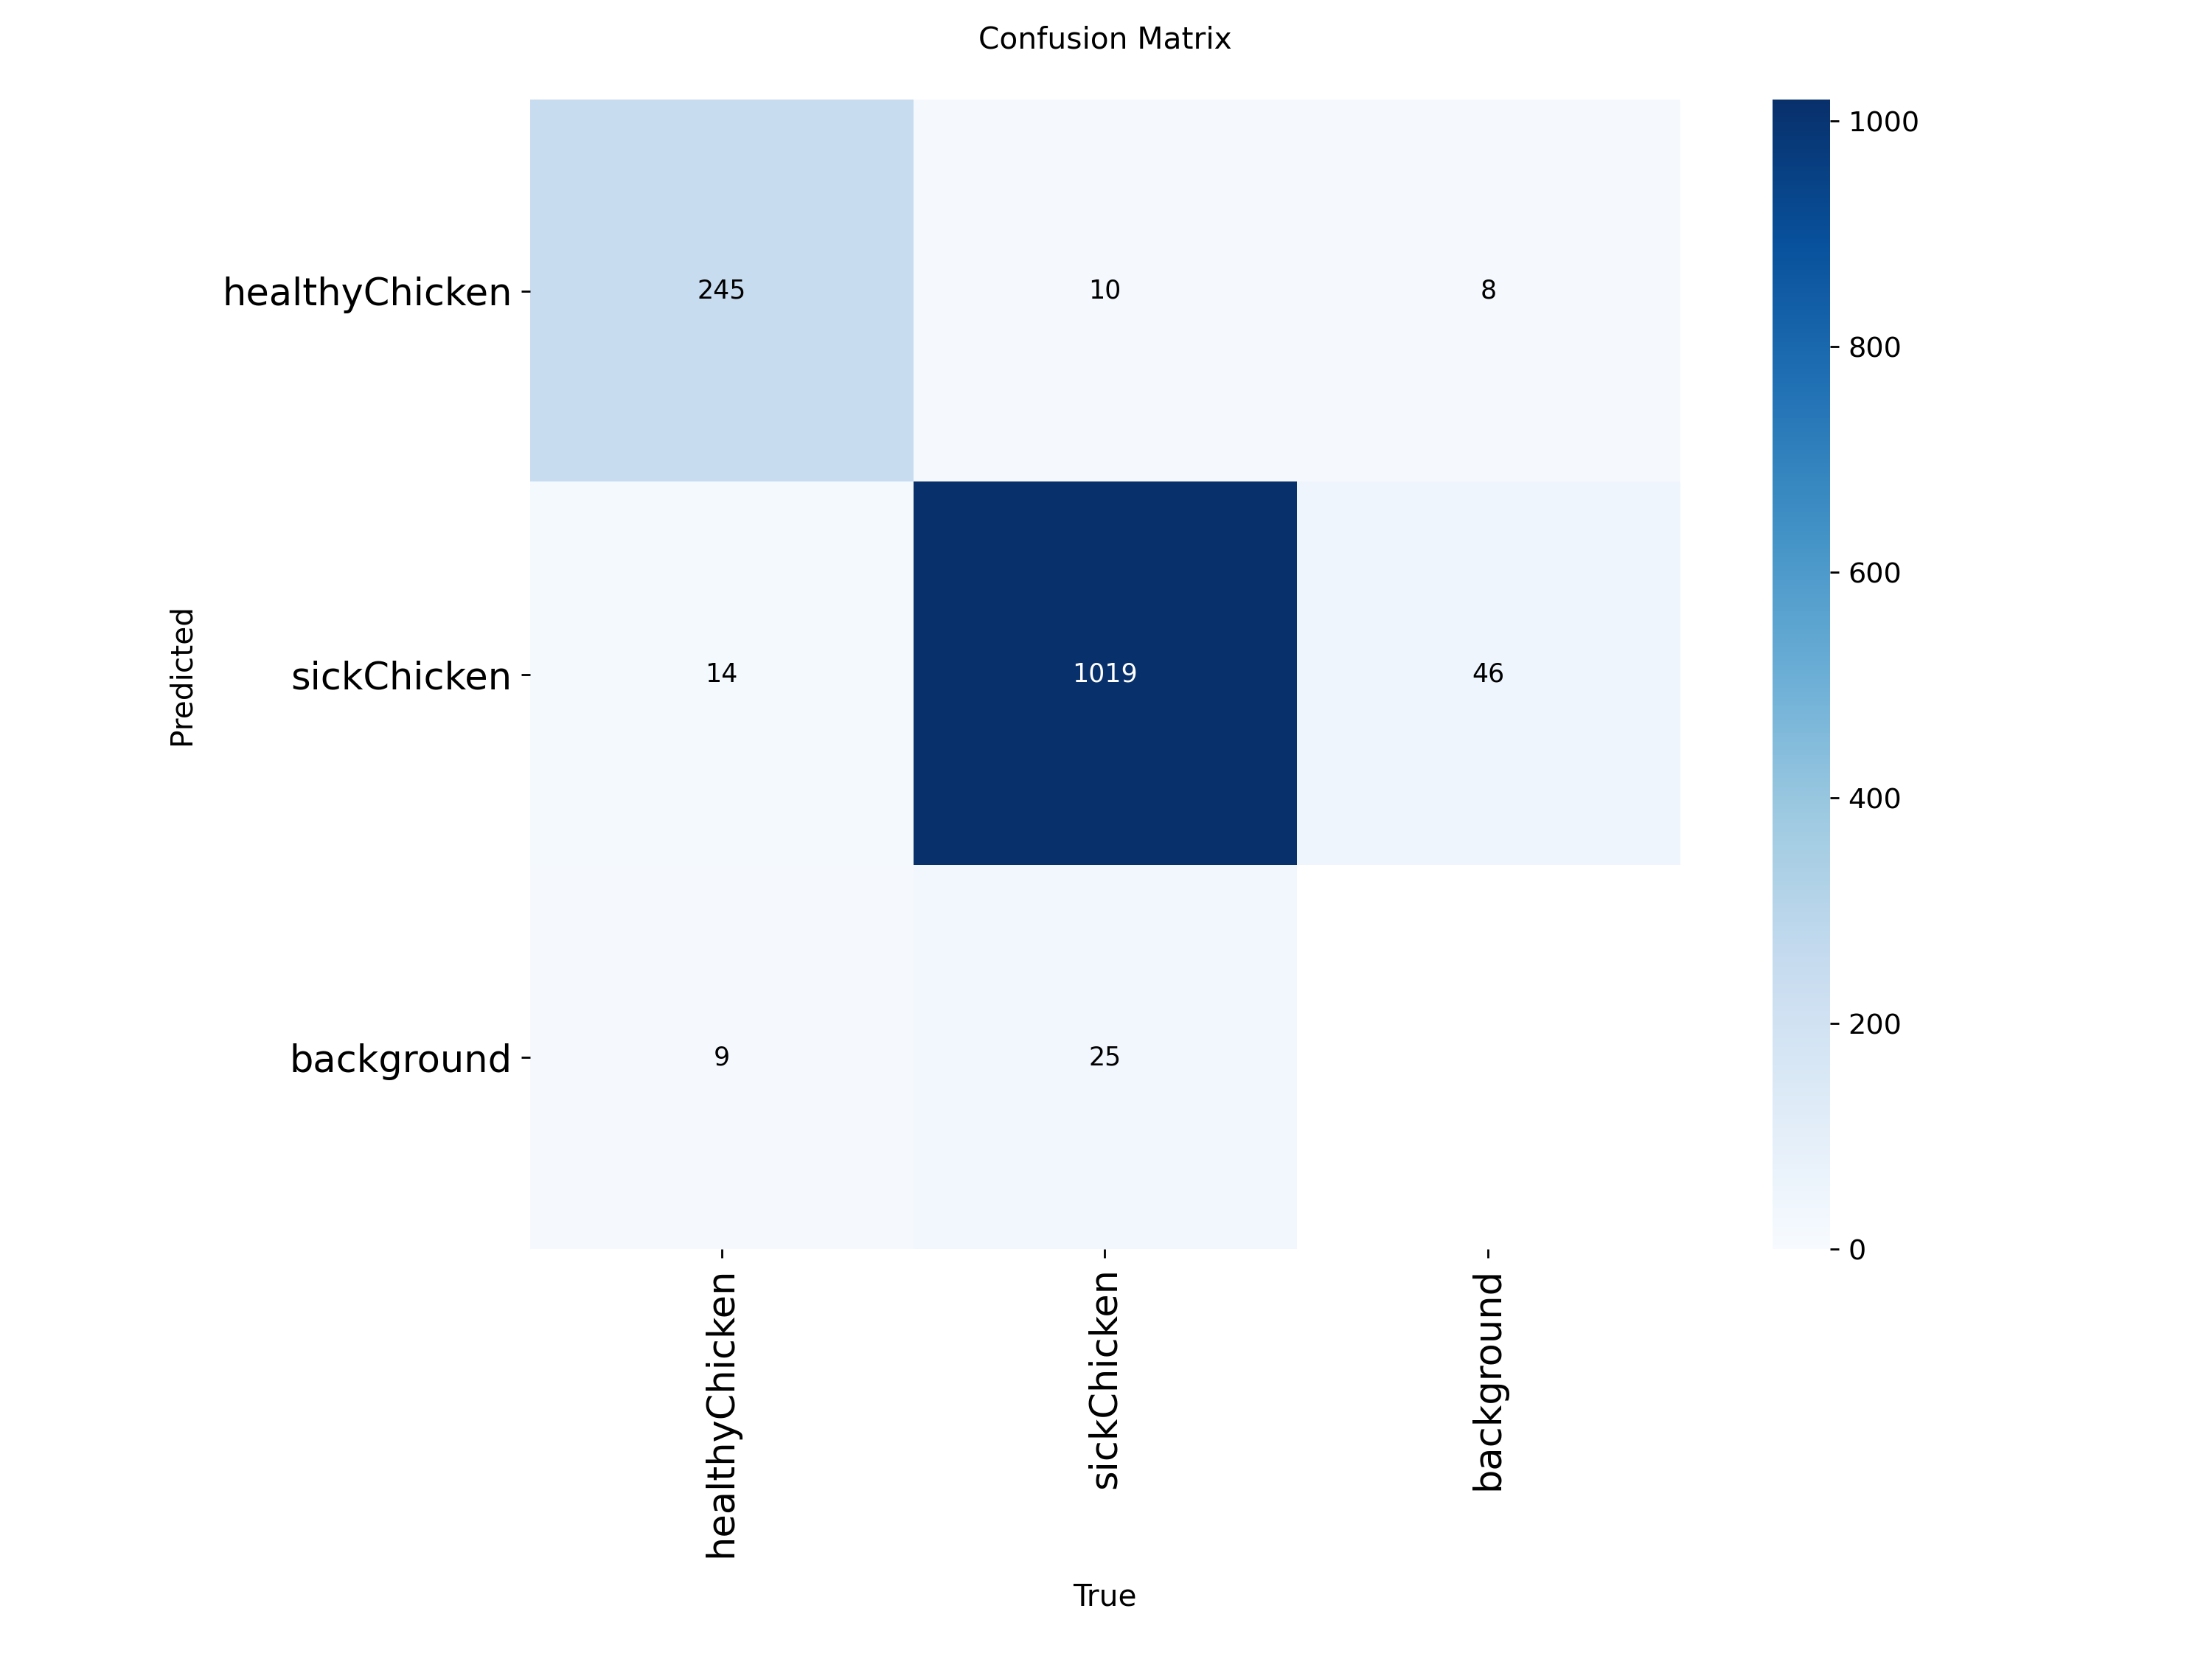


🎯 PREDICTIONS (Validation):


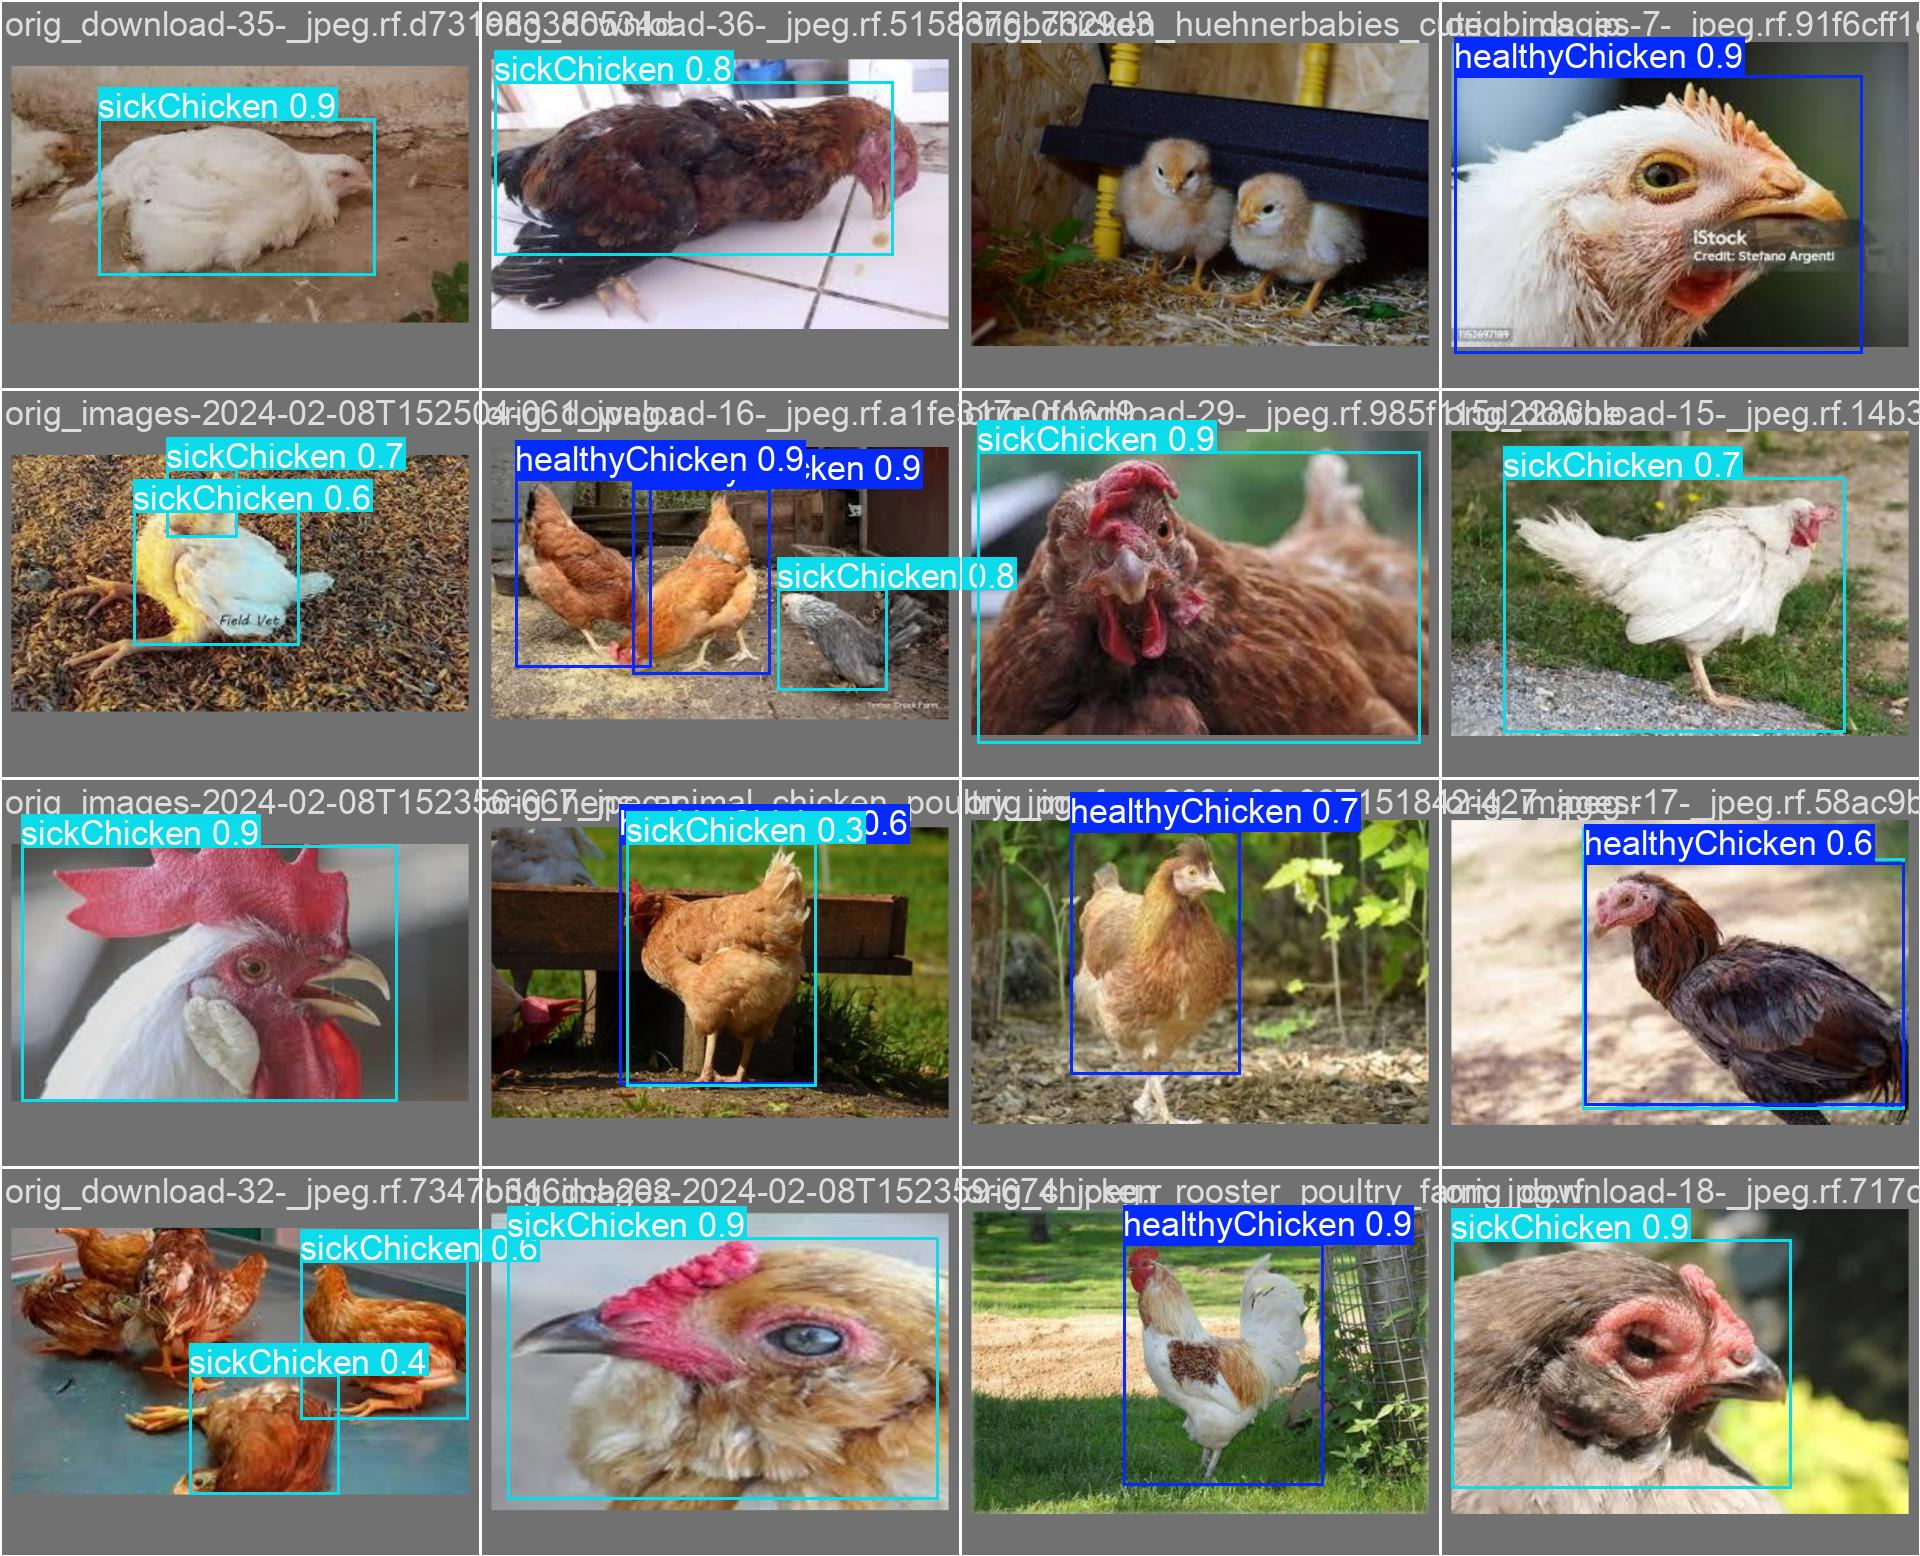

In [14]:
# Hiển thị training curves
from IPython.display import Image, display

print("📈 TRAINING CURVES:")
display(Image('/content/runs/detect/chicken_detection/results.png'))

print("\n📊 CONFUSION MATRIX:")
display(Image('/content/runs/detect/chicken_detection/confusion_matrix.png'))

print("\n🎯 PREDICTIONS (Validation):")
display(Image('/content/runs/detect/chicken_detection/val_batch0_pred.jpg'))

## 🔍 BƯỚC 8: TEST INFERENCE

In [15]:
# Test trên một vài ảnh
import random

test_images = list((DATASET_ROOT / 'test' / 'images').glob('*.jpg'))
sample_images = random.sample(test_images, min(5, len(test_images)))

print("🔍 INFERENCE ON TEST IMAGES:")
print("="*80)

for img_path in sample_images:
    results = best_model.predict(img_path, save=True, conf=0.25)
    print(f"\n✓ {img_path.name}")

    # In kết quả
    for r in results:
        boxes = r.boxes
        for box in boxes:
            cls = int(box.cls)
            conf = float(box.conf)
            class_name = 'healthyChicken' if cls == 0 else 'sickChicken'
            print(f"  - {class_name}: {conf:.2f}")

print("\n✓ Kết quả đã lưu tại: /content/runs/detect/predict/")

🔍 INFERENCE ON TEST IMAGES:

image 1/1 /content/merged_dataset/test/images/robo_0201-2-_jpg.rf.0c5134465ef0e95789196d9425a01ae3.jpg: 640x384 1 healthyChicken, 4 sickChickens, 65.7ms
Speed: 3.4ms preprocess, 65.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)
Results saved to /content/runs/detect/predict

✓ robo_0201-2-_jpg.rf.0c5134465ef0e95789196d9425a01ae3.jpg
  - healthyChicken: 0.90
  - sickChicken: 0.86
  - sickChicken: 0.85
  - sickChicken: 0.85
  - sickChicken: 0.29

image 1/1 /content/merged_dataset/test/images/robo_0434-2-_jpg.rf.b2a7b1521f00c425232674e30f94e340.jpg: 640x384 3 sickChickens, 10.8ms
Speed: 4.4ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)
Results saved to /content/runs/detect/predict

✓ robo_0434-2-_jpg.rf.b2a7b1521f00c425232674e30f94e340.jpg
  - sickChicken: 0.93
  - sickChicken: 0.85
  - sickChicken: 0.74

image 1/1 /content/merged_dataset/test/images/robo_0087_jpg.rf.8748982cc103be1bf75a10b37ad53380.

## 💾 BƯỚC 9: LƯU MODEL VỀ GOOGLE DRIVE

In [16]:
# Copy model về Google Drive
DRIVE_OUTPUT = '/content/drive/MyDrive/chicken_detection/trained_models'
!mkdir -p {DRIVE_OUTPUT}

# Copy best model
!cp /content/runs/detect/chicken_detection/weights/best.pt {DRIVE_OUTPUT}/chicken_detection_best.pt
!cp /content/runs/detect/chicken_detection/weights/last.pt {DRIVE_OUTPUT}/chicken_detection_last.pt

# Copy results
!cp /content/runs/detect/chicken_detection/results.png {DRIVE_OUTPUT}/
!cp /content/runs/detect/chicken_detection/confusion_matrix.png {DRIVE_OUTPUT}/

# Nén toàn bộ kết quả
!zip -r {DRIVE_OUTPUT}/chicken_detection_full_results.zip /content/runs/detect/chicken_detection/

print("✓ Đã lưu model và kết quả vào Google Drive!")
print(f"  Location: {DRIVE_OUTPUT}")
print("\nFiles:")
!ls -lh {DRIVE_OUTPUT}

  adding: content/runs/detect/chicken_detection/ (stored 0%)
  adding: content/runs/detect/chicken_detection/BoxPR_curve.png (deflated 20%)
  adding: content/runs/detect/chicken_detection/BoxP_curve.png (deflated 17%)
  adding: content/runs/detect/chicken_detection/val_batch0_pred.jpg (deflated 9%)
  adding: content/runs/detect/chicken_detection/train_batch0.jpg (deflated 2%)
  adding: content/runs/detect/chicken_detection/train_batch1.jpg (deflated 3%)
  adding: content/runs/detect/chicken_detection/confusion_matrix.png (deflated 30%)
  adding: content/runs/detect/chicken_detection/results.csv (deflated 71%)
  adding: content/runs/detect/chicken_detection/confusion_matrix_normalized.png (deflated 28%)
  adding: content/runs/detect/chicken_detection/weights/ (stored 0%)
  adding: content/runs/detect/chicken_detection/weights/best.pt (deflated 9%)
  adding: content/runs/detect/chicken_detection/weights/last.pt (deflated 9%)
  adding: content/runs/detect/chicken_detection/val_batch2_pred

## 📋 BƯỚC 10: TÓM TẮT KẾT QUẢ

In [17]:
print("="*80)
print("📊 TÓM TẮT KẾT QUẢ TRAINING")
print("="*80)

print(f"\n📂 Dataset:")
print(f"  - Train: {train_imgs} ảnh")
print(f"  - Valid: {valid_imgs} ảnh")
print(f"  - Test: {test_imgs} ảnh")
print(f"  - Total: {train_imgs + valid_imgs + test_imgs} ảnh")

print(f"\n🎯 Model: {model.model_name}")
print(f"  - Parameters: {sum(p.numel() for p in model.model.parameters()):,}")

print(f"\n📊 Performance (Validation):")
print(f"  - mAP@50: {val_metrics.box.map50:.4f} ({val_metrics.box.map50*100:.2f}%)")
print(f"  - mAP@50:0.95: {val_metrics.box.map:.4f} ({val_metrics.box.map*100:.2f}%)")
print(f"  - Precision: {val_metrics.box.mp:.4f} ({val_metrics.box.mp*100:.2f}%)")
print(f"  - Recall: {val_metrics.box.mr:.4f} ({val_metrics.box.mr*100:.2f}%)")

print(f"\n📊 Performance (Test):")
print(f"  - mAP@50: {test_metrics.box.map50:.4f} ({test_metrics.box.map50*100:.2f}%)")
print(f"  - mAP@50:0.95: {test_metrics.box.map:.4f} ({test_metrics.box.map*100:.2f}%)")
print(f"  - Precision: {test_metrics.box.mp:.4f} ({test_metrics.box.mp*100:.2f}%)")
print(f"  - Recall: {test_metrics.box.mr:.4f} ({test_metrics.box.mr*100:.2f}%)")

print(f"\n💾 Model đã lưu tại:")
print(f"  - Google Drive: {DRIVE_OUTPUT}")
print(f"  - Best model: chicken_detection_best.pt")

print("\n" + "="*80)
print("✅ HOÀN TẤT!")
print("="*80)
print("\nBước tiếp theo:")
print("  1. Download model về máy local")
print("  2. Test inference trên ảnh mới")
print("  3. Deploy model (API, web app, etc.)")

📊 TÓM TẮT KẾT QUẢ TRAINING

📂 Dataset:
  - Train: 2781 ảnh
  - Valid: 277 ảnh
  - Test: 117 ảnh
  - Total: 3175 ảnh

🎯 Model: yolov8n.pt
  - Parameters: 3,011,238

📊 Performance (Validation):
  - mAP@50: 0.9668 (96.68%)
  - mAP@50:0.95: 0.7038 (70.38%)
  - Precision: 0.9588 (95.88%)
  - Recall: 0.9390 (93.90%)

📊 Performance (Test):
  - mAP@50: 0.9570 (95.70%)
  - mAP@50:0.95: 0.6809 (68.09%)
  - Precision: 0.9535 (95.35%)
  - Recall: 0.9652 (96.52%)

💾 Model đã lưu tại:
  - Google Drive: /content/drive/MyDrive/chicken_detection/trained_models
  - Best model: chicken_detection_best.pt

✅ HOÀN TẤT!

Bước tiếp theo:
  1. Download model về máy local
  2. Test inference trên ảnh mới
  3. Deploy model (API, web app, etc.)
